In [50]:
pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00


In [51]:
import numpy as np
import pmdarima as pm
from pmdarima.arima import auto_arima

In [52]:
#Header files for Statistical model(ARIMA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

#Load the data into a pandas DataFrame
data = pd.read_csv("Project New.csv")
print(data.head())

# Read the dataset with timestamp column
df = pd.read_csv("Project New.csv")

# Convert the timestamp column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract date and time components
df['date'] = df['Timestamp'].dt.date
df['time'] = df['Timestamp'].dt.time

# Display the updated dataframe
print(df)
# Delete the original timestamp column
df = df.drop('Timestamp', axis=1)

# Display the updated dataframe
print(df)

# Reorder the columns
df.insert(0, 'time', df.pop('time'))
df.insert(0, 'date', df.pop('date'))

# Display the updated dataframe
print(df)

# Remove rows with NaN values
df = df.dropna()

# Display the updated dataframe
print(df)

# Derive the target variable: surplus or deficit
data["Target"] = data["To grid"] - data["From grid"]

# Basic Statistical Analysis of the target variable
target_stats = data["Target"].describe()

# Basic Statistical Analysis of the covariates
covariates_stats = data.drop(["Target", "To grid", "From grid"], axis=1).describe()

# Calculate the surplus/deficit by subtracting consumption from generation
data["surplus_deficit"] = data["To grid(cumulative)"] - data["From grid(cumulative)"]
print(data)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['From grid(cumulative)', 'To grid(cumulative)', 'surplus_deficit']])
print(data_scaled)
print(scaler)

# Split the data into train and test datasets
train_ratio = 0.8
train_size = int(len(data) * train_ratio)
train_data =data_scaled[:train_size]
test_data = data_scaled[train_size:]

# train data
print(train_data)

# test data
print(test_data)

             Timestamp  Irradiation horizontal  Irradiation vertical  \
0  01.01.2020 00:00:00               10.318919              6.182158   
1  01.01.2020 01:00:00               10.318919              6.182158   
2  01.01.2020 02:00:00               10.318919              6.182158   
3  01.01.2020 03:00:00               10.022490              6.046182   
4  01.01.2020 04:00:00                2.803804              2.734858   

   Humidity outside  Temperature outside  El. Energy Heating/Cooling  \
0         75.287622            -0.402457                    0.166755   
1         80.022013            -1.082696                    0.169691   
2         81.353654            -0.889972                    0.163549   
3         82.054028            -1.018735                    0.163930   
4         83.898655            -1.792509                    0.135606   

   El. Energy Heating/Cooling(cumulative)  El. Energy house  \
0                             41067.03129               1.0   
1       

In [53]:
# Convert the train_data and test_data back to their original scale
train_data_original = scaler.inverse_transform(train_data)
test_data_original = scaler.inverse_transform(test_data)

In [54]:
print(train_data_original )

[[ 340437.57   91483.71 -248953.86]
 [ 340438.89   91483.71 -248955.18]
 [ 340440.24   91483.71 -248956.53]
 ...
 [ 365007.99  171369.15 -193638.84]
 [ 365016.36  171369.15 -193647.21]
 [ 365027.4   171369.15 -193658.25]]


In [55]:
print(test_data_original)

[[ 365028.75  171369.15 -193659.6 ]
 [ 365030.19  171369.15 -193661.04]
 [ 365031.6   171369.15 -193662.45]
 ...
 [ 375412.08  179548.95 -195863.13]
 [ 375414.18  179548.95 -195865.23]
 [ 375416.31  179548.95 -195867.36]]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Mean Squared Error: 4.694897696383614e+19


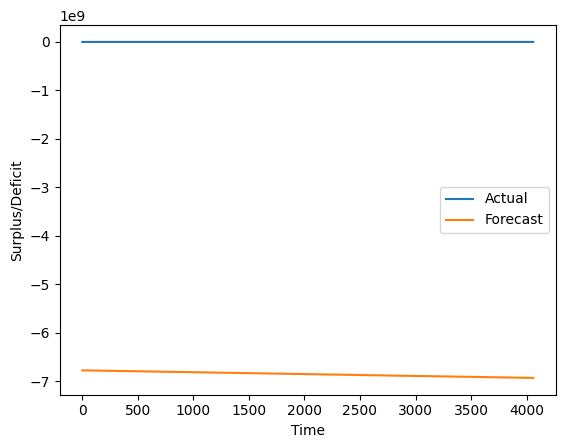

In [56]:
# Select the "surplus_deficit" column as the endogenous variable
endog_variable = train_data_original[:, 2]

# Use auto_arima to find the best ARIMA parameters
best_model = auto_arima(endog_variable, seasonal=False, stepwise=True, suppress_warnings=True)

# Get the best order (p, d, q) from the search
best_order = best_model.order

# Define the ARIMA model with the best parameters
model = ARIMA(endog_variable, order=best_order)

# Fit the ARIMA model
model_fit = model.fit()

# Forecast on the test data
forecast_values = model_fit.forecast(steps=len(test_data))

# Convert forecast_values to a 2D array with a single column
forecast_values_2d = forecast_values.reshape(-1, 1)

# Create zeros for the other two columns (assuming 4061 data points)
zeros_for_other_features = np.zeros((4061, 2))

# Concatenate the forecasted values and zeros to create a 2D array with three columns
forecast_values_2d_with_zeros = np.concatenate((forecast_values_2d, zeros_for_other_features), axis=1)

# Invert the forecasted values back to the original scale
forecast_values_original = scaler.inverse_transform(forecast_values_2d_with_zeros)

# Calculate the mean squared error between the actual test data and forecasted values
mse = mean_squared_error(test_data_original[:, 2], forecast_values_original[:, 0])  # Assuming the 3rd column is the "Surplus/Deficit"
print("Mean Squared Error:", mse)

# Plot the actual test data and the forecasted values
import matplotlib.pyplot as plt

time_index = range(len(test_data_original))  # Create a time index for the test data

plt.plot(time_index, test_data_original[:, 2], label='Actual')
plt.plot(time_index, forecast_values_original[:, 0], label='Forecast')  # Assuming the 3rd column is the "Surplus/Deficit"
plt.xlabel('Time')
plt.ylabel('Surplus/Deficit')
plt.legend()
plt.show()

In [57]:
best_order

(2, 2, 3)